# Simulating the same star with multiple PSFs

ScopeSim has several Effect classes to simulate a PSF (Point Spread Function). This notebook verifies that they are all consistent.

In [1]:
%matplotlib inline
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u
import yaml
from pprint import pprint
import copy
from astropy.io import fits

import scopesim as sim
import scopesim_templates as sim_tp

## Set up a source with a single star

We use a single star as source.

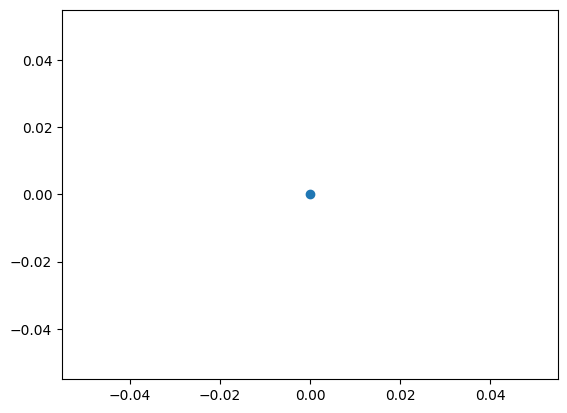

In [2]:
stars = sim_tp.star("Ks", 15)

plt.scatter(stars.fields[0]["x"], stars.fields[0]["y"])

# Setup Hardware

We will simulate the star in an matrix of multiple hardware setups:

- two detectors, one with an odd number of pixels, and one with an even number of pixels,
- two telesopes, one with an anlytical SeeingPSF and one with a numerical FieldConstantPSF,
- two different observations, one without subpixel rendering, one with

The FITS file with the PSF for the FieldConstantPSF is generated from the SeeingPSF simulation.

In [3]:
yaml_detector_odd = {
    'alias': 'DET',
    'description': 'The detector and electronic properties and effects',
    'name': 'detectorodd',
    'object': 'detector',
    'properties': {
        'dit': '!OBS.dit',
        'image_plane_id': 0,
        'ndit': '!OBS.ndit',
        'temperature': -230,
        'width': 11,
        'height': 11,
        'x': 0,
        'y': 0,
    },
    'effects': [{
        'name': 'detector_window',
        'class': 'DetectorWindow',
        'description': 'Cut-out of the focal plane image with custom dimensions and coordinates',
        'kwargs': {
            'height': '!DET.height',
            'image_plane_id': 0,
            'pixel_size': 0.01,
            'units': 'pixel',
            'width': '!DET.width',
            'x': '!DET.x',
            'y': '!DET.y',
        },
    }],
}

yaml_detector_even = copy.deepcopy(yaml_detector_odd)
yaml_detector_even["name"] = "detectoreven"
yaml_detector_even["properties"]["width"] = 12
yaml_detector_even["properties"]["height"] = 12

yamls_detector = [yaml_detector_even, yaml_detector_odd]

In [4]:
yaml_instrument = {
    "object": "instrument",
    "alias": "INST",
    "name": "basic_instrument",
    "description": "Effects from the common optics",
    
    "properties": {
        "temperature": -190.,
        "pixel_scale": 0.2,       # arcsec / pixel
        "plate_scale": 20.,        # arcsec / mm
        # "pixel_size": 0.01,    # mm / pixel
    },
    
    "effects": [{
        "name": "static_surfaces",
        "description": "surfaces list for common optics",
        "class": "SurfaceList",
        "kwargs": {
            # "filename": "INS_common_optics.dat",
            "array_dict": {
                "name": ["entr_window"],
                "outer": [0.5],
                "inner": [0.0],
                "angle": [0.0],
                "temperature": [7.0],
                "action": ["transmission"],
                "filename": ["INS_unity_trans.dat"],
            },
        },
    }],
}

In [5]:
yaml_telescope_nopsf = {
    "object": "telescope",
    "alias": "TEL",
    "name": "telescopenopsf",
    "description": "The telescope",
    
    "properties": {
        "temperature": 0.,
    },
    
    "effects": [],
}

In [6]:
yaml_telescope_seeingpsf = {
    "object": "telescope",
    "alias": "TEL",
    "name": "telescopeseeingpsf",
    "description": "The telescope",
    
    "properties": {
        "temperature": 0.,
    },
    
    "effects": [{
        "name": "psf",
        "description": "Seeing limited PSF",
        "class": "SeeingPSF",
        "kwargs": {
            "fwhm": "!OBS.psf_fwhm", # [arcsec]
        },
    }],
}

In [7]:
yaml_telescope_fieldconstantpsf = {
    "object": "telescope",
    "alias": "TEL",
    "name": "telescopefieldconstantpsf",
    "description": "The telescope",
    
    "properties": {
        "temperature": 0.,
    },
    
    "effects": [{
        "name": "psf",
        "description": "Copy of Seeing limited PSF",
        "class": "FieldConstantPSF",
        "kwargs": {
            "filename": "seeingpsfinput.fits", # Created below
        },
    }],
}

In [8]:
yamls_telescope = [
    yaml_telescope_nopsf,
    yaml_telescope_seeingpsf,
    yaml_telescope_fieldconstantpsf,
]

In [9]:
observation_dict_without_sub_pixel = {
    "name": "observationnosubpixel",
    
    "!OBS.filter_name_pupil": "Pa-beta",
    "!OBS.filter_name_fw1": "open",
    "!OBS.filter_name_fw2": "open", 
    "!INST.filter_name": "Pa-beta",
    "!OBS.ndit": 20, 
    "!OBS.dit": 3,
    "!OBS.exptime": 60,

    "!OBS.instrument": "MyInstrument",
    "!OBS.catg": "SCIENCE",
    "!OBS.tech": "IMAGE",
    "!OBS.type": "OBJECT",
    "!OBS.mjdobs": datetime.datetime(2022, 1, 1, 2, 30, 0),


    "!OBS.psf_fwhm": 1.5,             # [arcsec]
    "!OBS.slit_name": "narrow",

    "!OBS.include_slit": False,
    "!OBS.include_slicer": False,
    "!OBS.filter_name": "J",

    "!TEL.temperature": 7.0,

    "!INST.temperature": -190,
    "!INST.pixel_scale": 0.2,       # arcsec / pixel
    "!INST.plate_scale": 20,        # arcsec / mm

    "!OBS.modes": ["imaging"],
    "!TEL.telescope": "EvLT",
    "!ATMO.location": "Here",

    # sub_pixel.flag also moves by half a pixel
    "!SIM.sub_pixel.flag": False,
    # "!SIM.sub_pixel.flag": True,
}

observation_dict_with_sub_pixel = copy.copy(observation_dict_without_sub_pixel)
observation_dict_with_sub_pixel["name"] = "observationsubpixel"
observation_dict_with_sub_pixel["!SIM.sub_pixel.flag"] = True

observation_dicts = [observation_dict_without_sub_pixel, observation_dict_with_sub_pixel]

In [10]:
def simulate_star(
    yaml_telescope=None,
    yaml_detector=None,
    observation_dict=None,
):
    cmd = sim.UserCommands(
        yamls = [
            yaml_telescope,
            yaml_instrument,
            yaml_detector,
        ],
        
        properties=copy.deepcopy(observation_dict),
    )
    opticaltrain = sim.OpticalTrain(cmd)
    opticaltrain.observe(stars)
    hdus = opticaltrain.readout()

    hdu = hdus[0]
    data = hdu[1].data
    k = (yaml_telescope["name"], yaml_detector["name"], observation_dict["name"])
    stats = (data.sum(), data.min(), data.max())

    
    fig, ax1 = plt.subplots(figsize=(10,10))
    ax1.imshow(hdu[1].data)
    ax1.set_title(" ".join(k) + "\n" + str(stats))

    print(data.sum(), data.min(), data.max())
    return hdu


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
20058.71099899009 32.060552101142264 373.183707703554


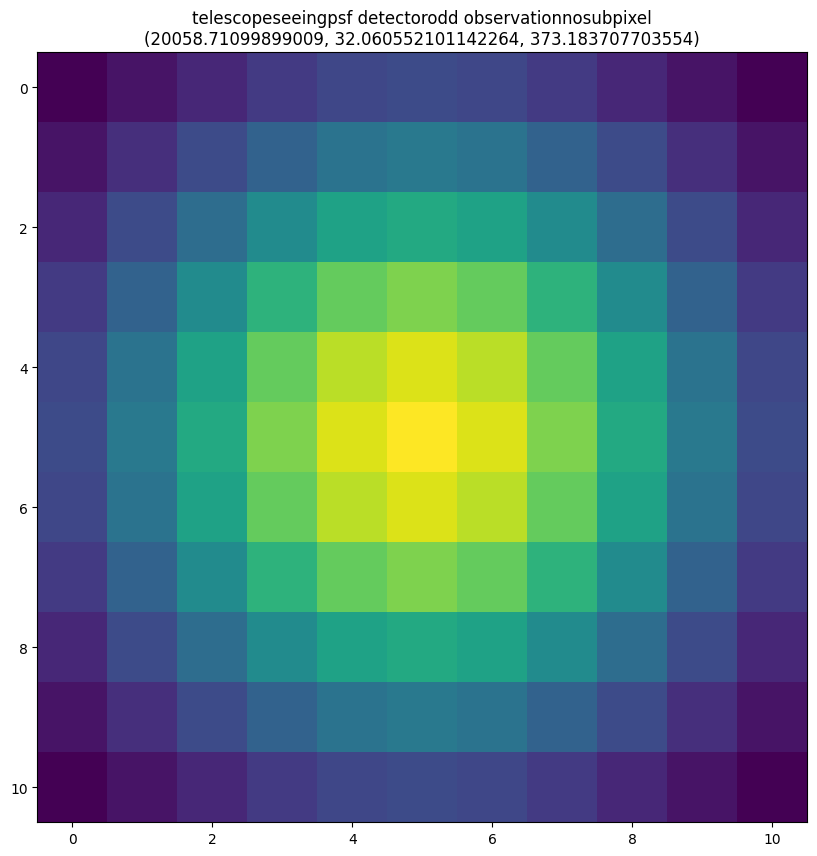

In [11]:
hdus_seeingpsf_odd_nosubpixel = simulate_star(
    yaml_telescope=yaml_telescope_seeingpsf,
    yaml_detector=yaml_detector_odd,
    observation_dict=observation_dict_without_sub_pixel,
)
hdus_seeingpsf_odd_nosubpixel[1].header["WAVE0"] = 1.6
hdus_seeingpsf_odd_nosubpixel[1].header
hdus_seeingpsf_odd_nosubpixel.writeto("seeingpsfinput.fits", overwrite=True)


astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
23881.991752565238 0.0 23881.991752565238
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
23881.991752565238 0.0 5970.4979381413095
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
23881.991752565238 0.0 23881.991752565238
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
23881.991752565238 0.0 23881.991752565238
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
21004.267665423526 10.888103948231691 373.183707703554
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
21004.267665423526 20.078986959645245 355.5209905813832
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
20058.71099899009 32.060552101142264 373.183707703554
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
20058.71099899009 32.060552101142264 373.183707703554
astar.scopesim.detect

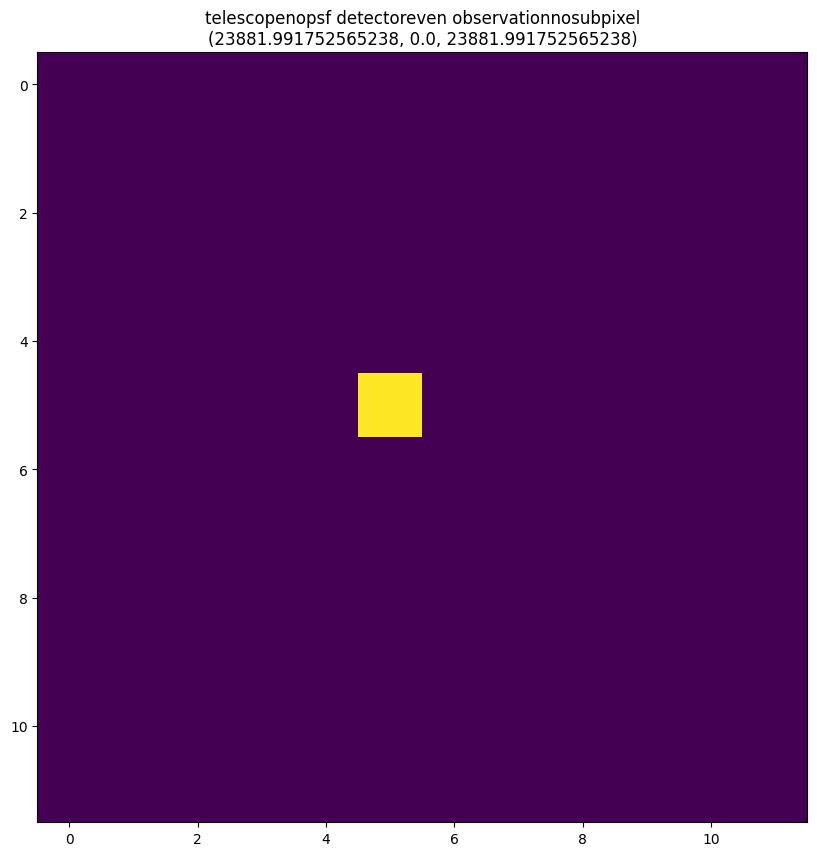

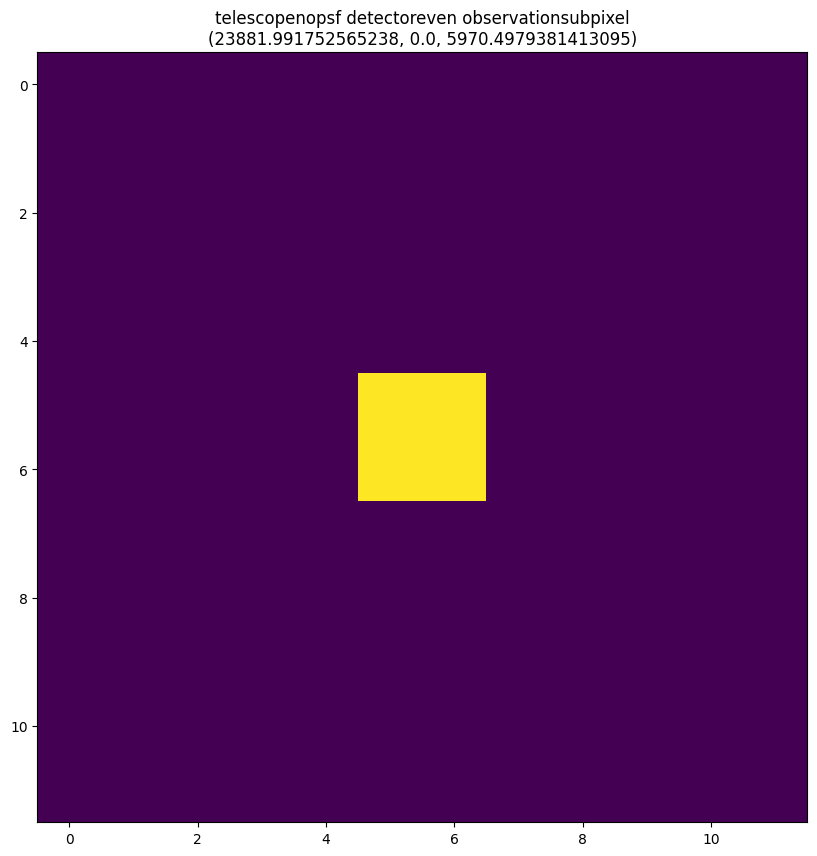

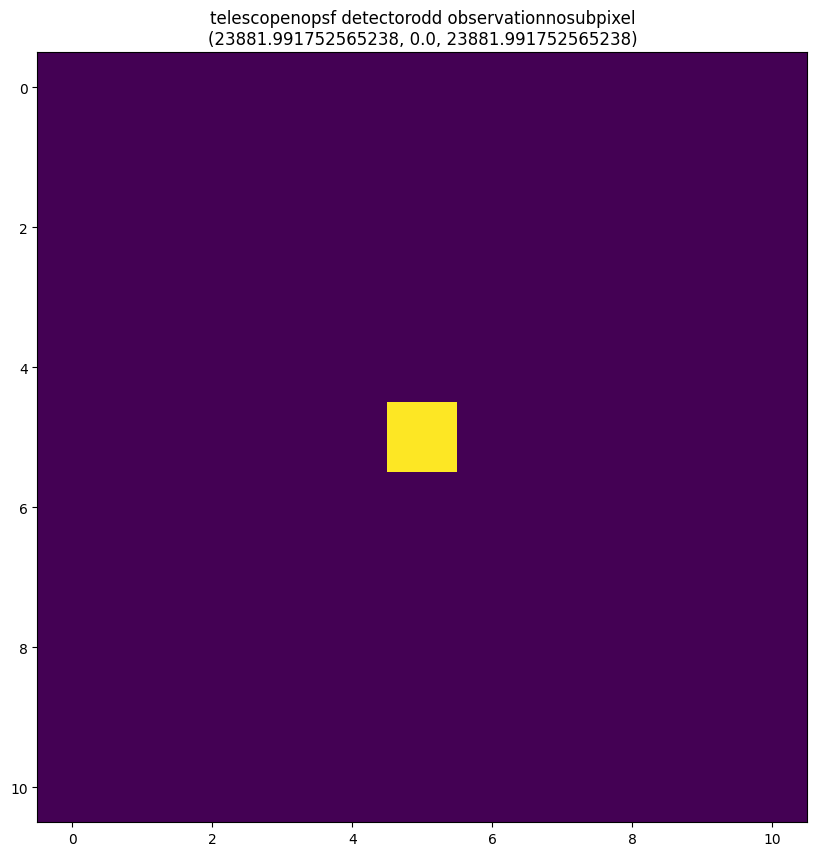

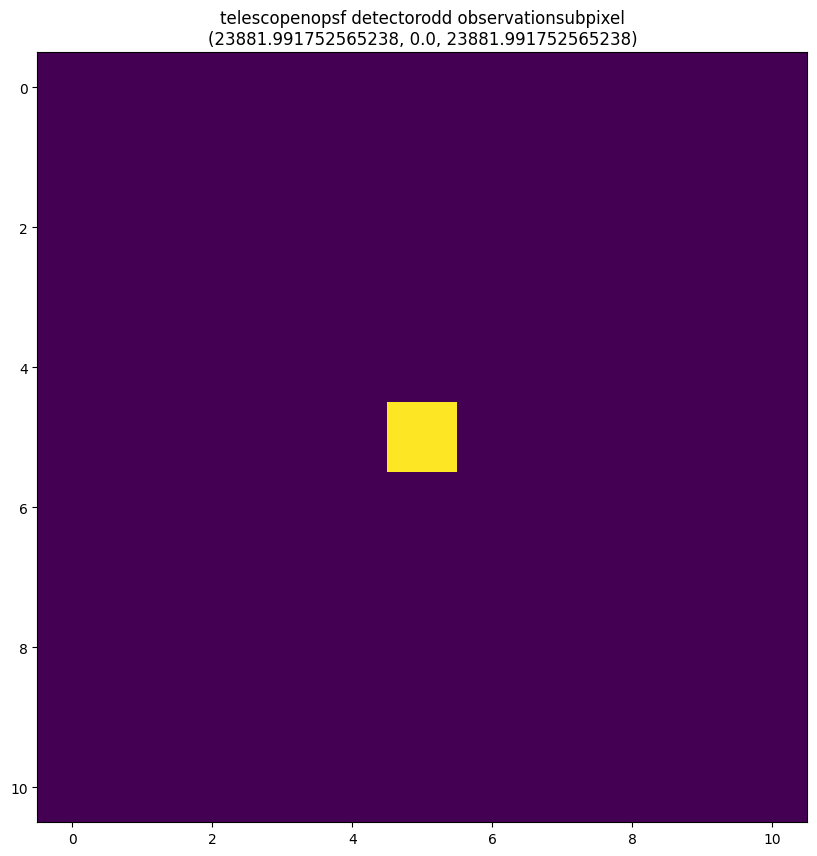

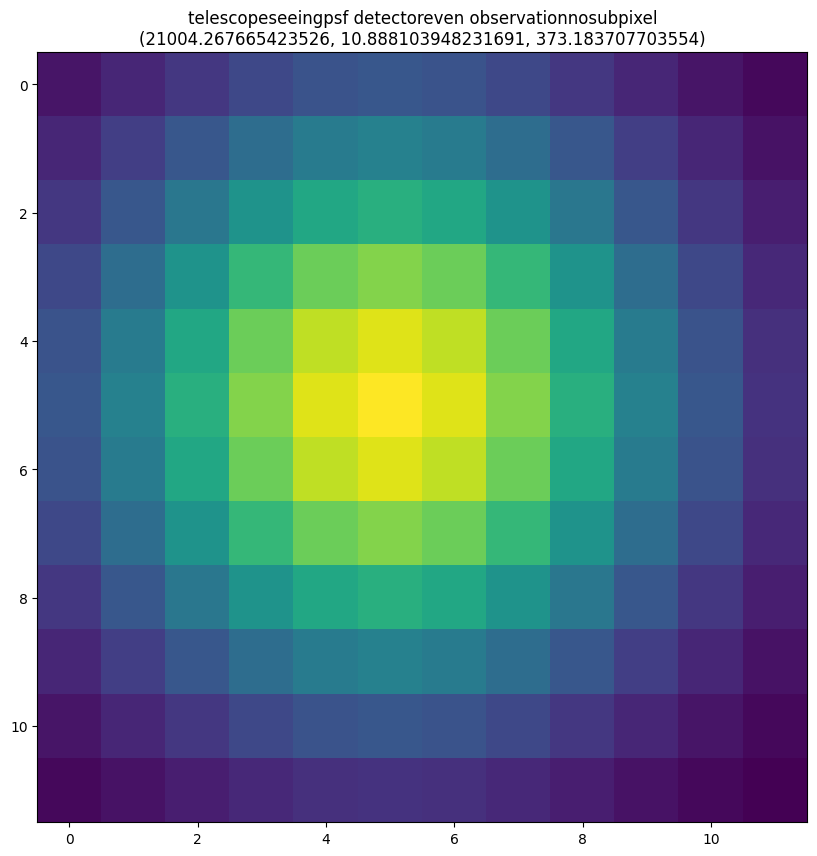

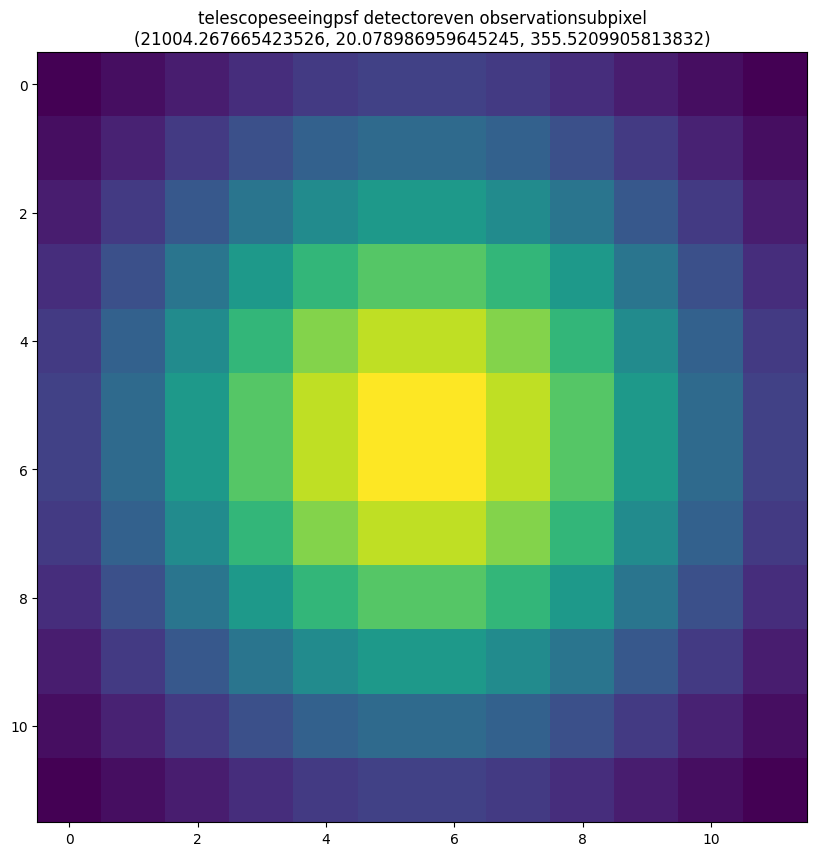

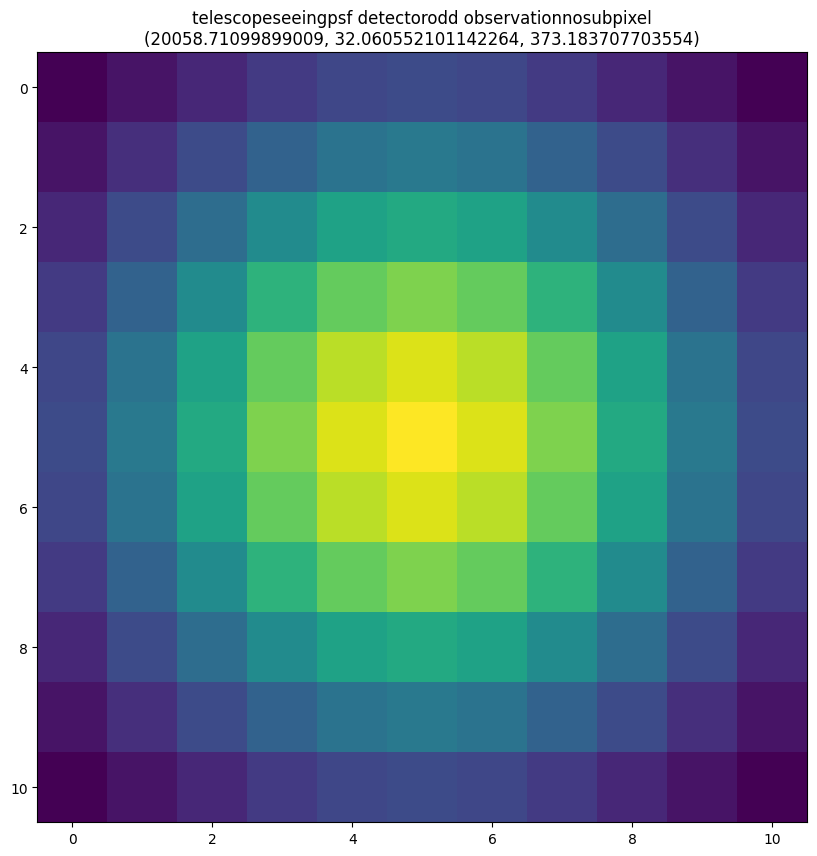

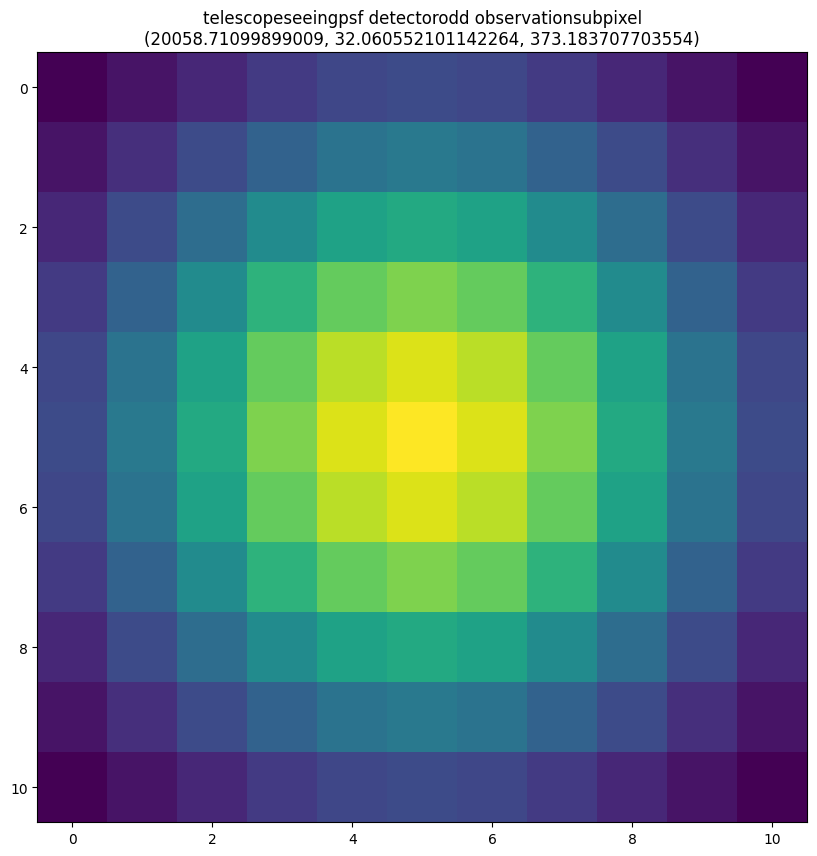

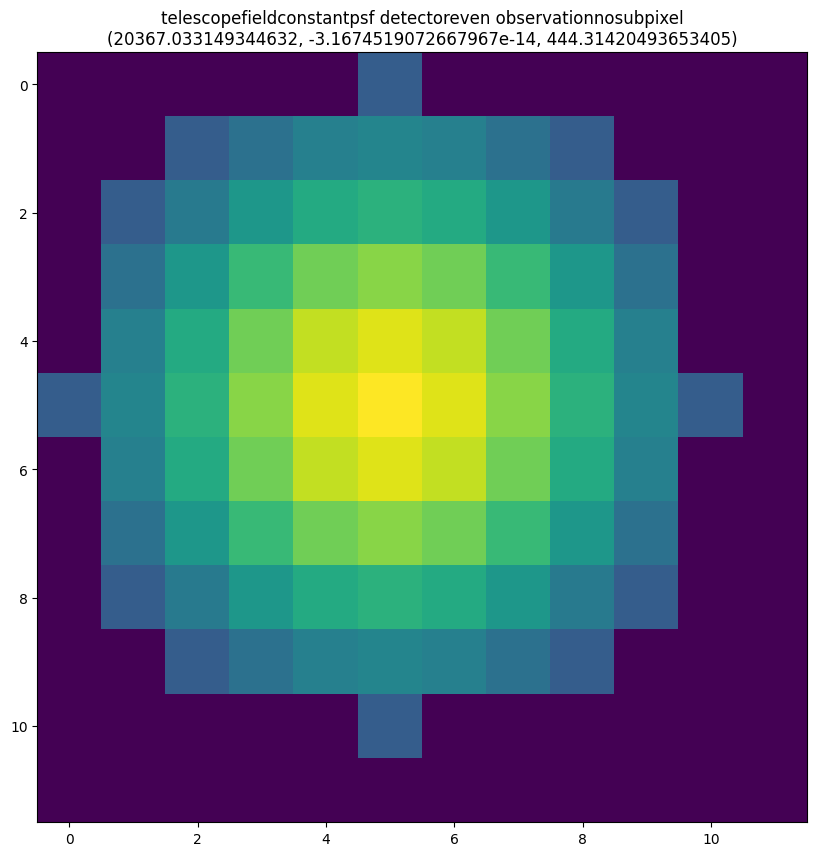

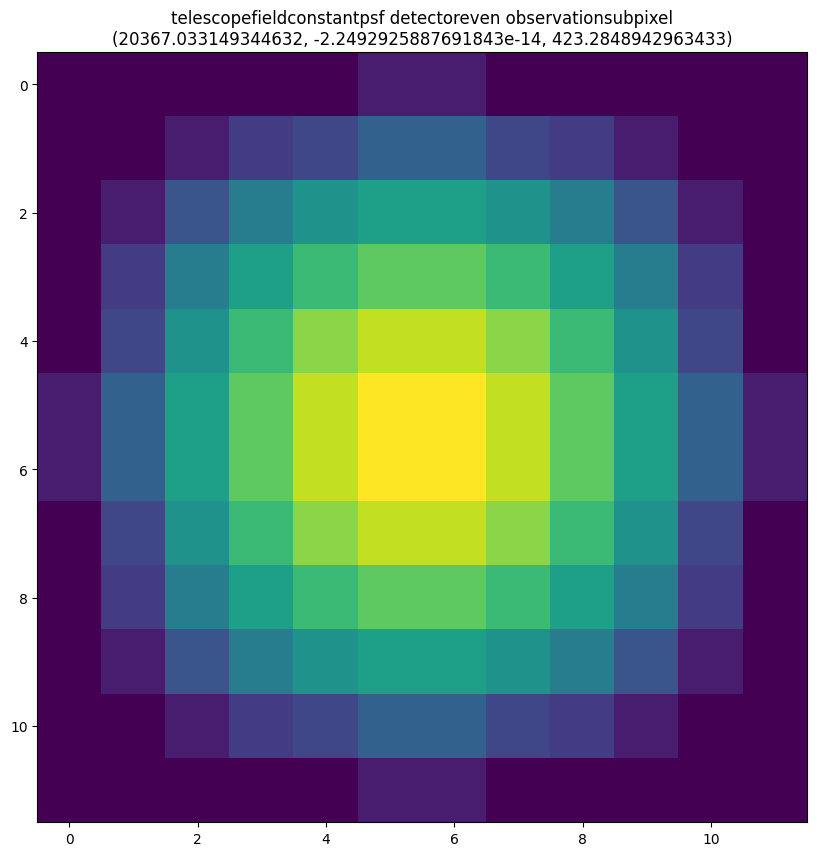

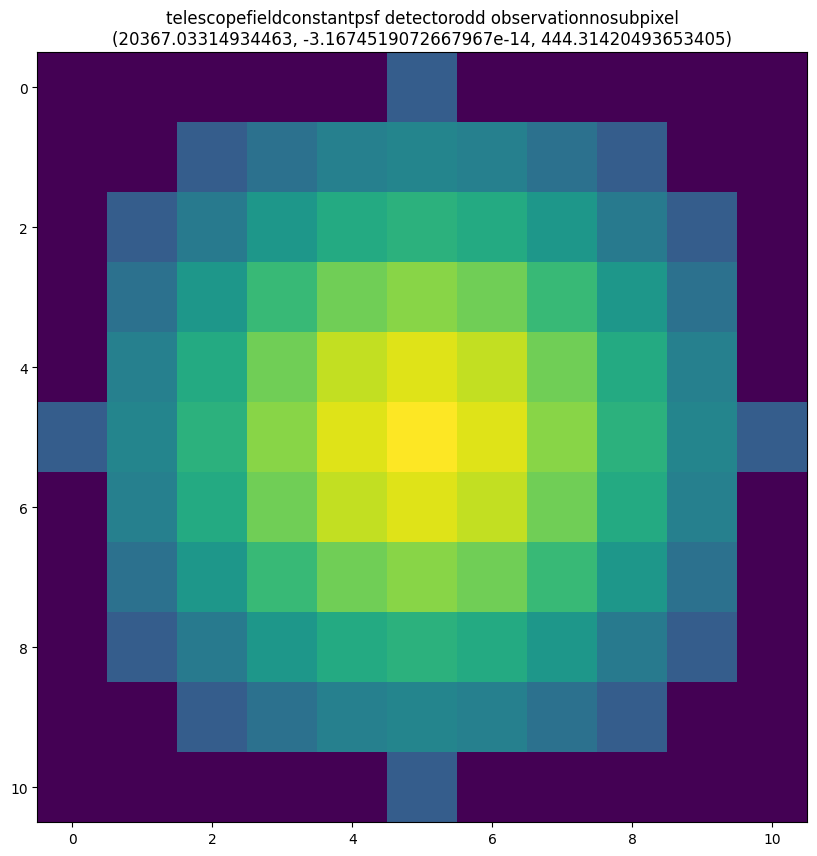

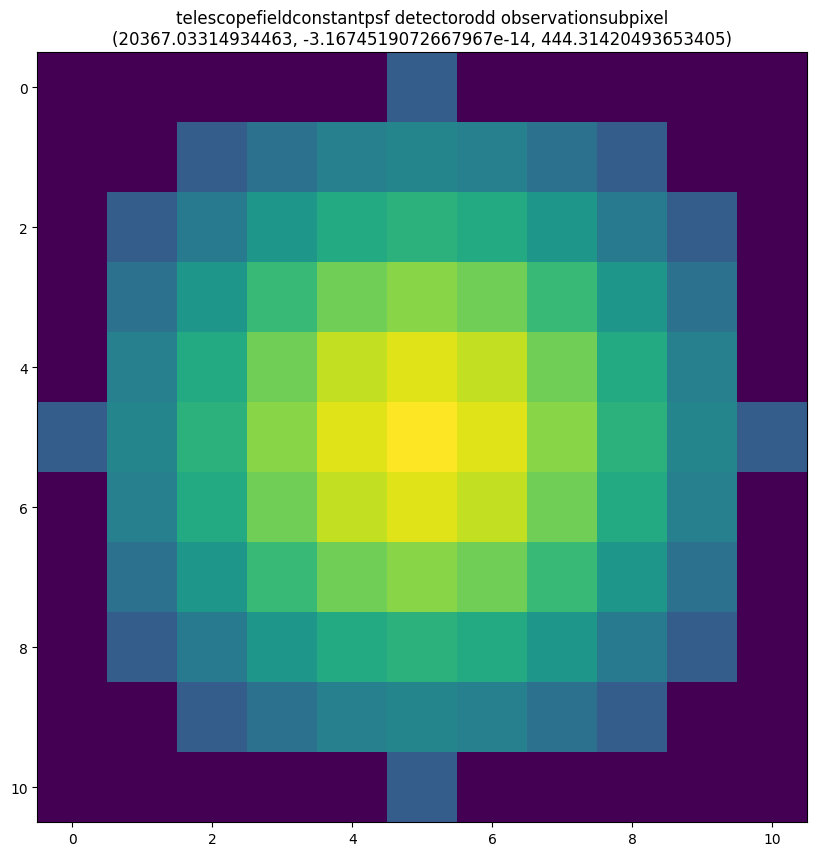

In [12]:
simulations = {
    (
        yaml_telescope["name"], yaml_detector["name"], observation_dict["name"]
    ): simulate_star(
        yaml_telescope,
        yaml_detector,
        observation_dict,
    )
    for yaml_telescope in yamls_telescope
    for yaml_detector in yamls_detector
    for observation_dict in observation_dicts
}